#  Minerva and Dami's model and training test
This notebook is a test notebook to create a TCGAN model minverva-like for the purpose to insert this model onto the new GANs Module which is being updated. 

On this notebook is going to be presented the way Dami used the TCGAN Model (That we are calling Dami's model) and how he trained it, this is going to help us create a new TCGAN model outside this notebook, and then we are going to train it the same way we did with the Dami's model, and compare the graphs to see if it is training the same way with all the datasets.

After we are going to train both models with the Minerva's GANs training infrastructure, this way, we can see if the GAN training as Dami did and as Minerva is presented are compatible and if the Minerva-like model and Dami's model are compatible.



## Dami's training

### Important imports

In [5]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
from torchsummary import summary

import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm
import time
import os
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

from minerva.models.nets.time_series.gans import GAN, TTSGAN_Encoder, TTSGAN_Discriminator, TTSGAN_Generator
from minerva.data.data_module_tools import RandomDataModule
import torch
import lightning as L

from torch.utils.data import DataLoader, TensorDataset

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device = 'cpu'

print(f"Using {device} device")

Using cpu device


In [7]:
n_epochs = 2
activities = ['sit', 'stand', 'walk', 'upstairs', 'downstairs','run']

The experiments in this notebook will proceed in this order:

1. present the already stablished model from authors;
2. train this stablished model with the training the authors suggested;
3. present the enhanced model (for the purpose of test to adjust it to the minerva framwork);
4. train this enhanced model with the training the author suggested;
5. train the stablished model with the training created in the minerva framework;
6. train the enhanced model with the training created in the minerva framework;

On every step will be created a new .pth dict with both the generator and discriminator in the same file, for easy access of every step of the way, the files will have this structure:

``` 
experiments/
├── experiment_1_author_newly_untrained/
│   ├── discriminator/
│   └── generator/
├── experiment_2_author_author_training/
│   ├── discriminator/
│   └── generator/
├── experiment_3_enhanced_newly_untrained/
│   ├── discriminator/
│   └── generator/
├── experiment_4_enhanced_author_training/
│   ├── discriminator/
│   └── generator/
├── experiment_5_author_minerva_training/
│   ├── discriminator/
│   └── generator/
└── experiment_6_enhanced_minerva_training/
    ├── discriminator/
    └── generator/
``` 
the experiments name follow: experiment_number_model_type_training

### Data definitions and processing

In [8]:
#!wget https://zenodo.org/records/11992126/files/standardized_view.zip?download=1

In [9]:
SAC = ['Sit', 'Stand', 'Walk', 'Upstairs', 'Downstairs', 'Run']
newpath = r'../../standardize_view'
number = 2
save_path = f'./trained_models/{number}/'
list_of_experiments = ['experiment_1_author_newly_untrained', 'experiment_2_author_author_training',
                       'experiment_3_enhanced_newly_untrained', 'experiment_4_enhanced_author_training',
                       'experiment_5_author_minerva_training', 'experiment_6_enhanced_minerva_training']
experiment_path_list = [save_path + experiment for experiment in list_of_experiments]
if os.path.exists(newpath):
   print("Directory already exists")
else:
    os.makedirs(newpath)
    print("Directory created")
    !unzip ../../standardized_view.zip?download=1 -d standardize_view
   
experiment_path_list

Directory already exists


['./trained_models/2/experiment_1_author_newly_untrained',
 './trained_models/2/experiment_2_author_author_training',
 './trained_models/2/experiment_3_enhanced_newly_untrained',
 './trained_models/2/experiment_4_enhanced_author_training',
 './trained_models/2/experiment_5_author_minerva_training',
 './trained_models/2/experiment_6_enhanced_minerva_training']

In [10]:
def save_model(generator, discriminator, ID, path_list = experiment_path_list):
    dict = {'gen_state_dict': generator.state_dict(),
        'dis_state_dict': discriminator.state_dict()}
    if not os.path.isdir(path_list[ID]):
        print('creating directory', path_list[ID])
        os.makedirs(path_list[ID])

    print('saving model in ', path_list[ID] + '/model.pth')
    torch.save(dict, path_list[ID] + '/model.pth')

In [11]:
dataNames = os.listdir(newpath)
dataNames.sort()
dataNames

['KuHar', 'MotionSense', 'RealWorld_thigh', 'RealWorld_waist', 'UCI', 'WISDM']

In [12]:
X = []
y = []   
for dataName in dataNames:
    print(dataName)
    dfTr = pd.read_csv(newpath + '/' + dataName + '/train.csv')
    X_tr = dfTr.values[:,:360].reshape(-1,6,60)
    y_tr = dfTr.values[:,-1].astype(np.int32)
    X.append(X_tr)
    y.append(y_tr)
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)
X.shape, y.shape

KuHar
MotionSense
RealWorld_thigh
RealWorld_waist
UCI
WISDM


((36788, 6, 60), (36788,))

### Data vizualization

/tmp/ipykernel_18783/2505372687.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


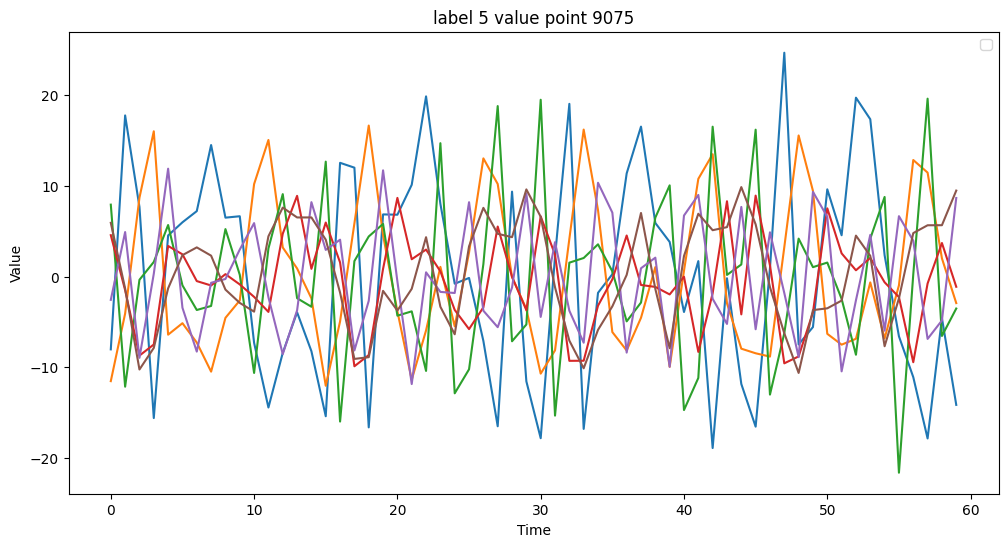

In [13]:
import matplotlib.pyplot as plt

# Select the specific data point
a = np.random.randint(0, X.shape[0])
data_point = X[a]

# Plot the data point
plt.figure(figsize=(12, 6))
for i in range(data_point.shape[0]):
    plt.plot(data_point[i])
plt.title(f'label {y[a]} value point {a}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### Important Functions and definitions

#### Network constants

In [14]:
input_shape = (60,6)
generated_sample_shape = input_shape
noise_shape = 100
input_layer = noise_shape

n_layers = 4
kernel_size = 10
strides = 2
g_units_base=32

#Definições fixas para o modelo (Pode ser gerado pelo próprio modelo)
steps = generated_sample_shape[0]
layer_steps = [steps]
for i in range(n_layers):
    layer_steps.append(int(np.ceil(float(layer_steps[-1]) / float(strides))))
layer_steps.reverse()

conv_units = []
if n_layers > 1:
    conv_units.append(g_units_base)
    for _ in range(n_layers - 2):  # minus the first and the last layers
        conv_units.append(conv_units[-1] * 2)
conv_units.reverse()
# the last layer must be aligned to the number of dimensions of input.
conv_units.append(generated_sample_shape[-1])

conv_units, layer_steps, input_shape, input_layer

([128, 64, 32, 6], [4, 8, 15, 30, 60], (60, 6), 100)

In [15]:
units = [32]
for _ in range(n_layers - 1):  # exclude the first layer.
    units.append(units[-1] * 2)



In [16]:
print('input shape:', input_layer)
print('units:', units)
print('conv_units:', conv_units)
print('layer_steps:', layer_steps)

input shape: 100
units: [32, 64, 128, 256]
conv_units: [128, 64, 32, 6]
layer_steps: [4, 8, 15, 30, 60]


#### Network definition

In [17]:
class Genera(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(input_layer, layer_steps[0] * conv_units[0] * 2, device=device)
        self.l2 = nn.BatchNorm1d(layer_steps[0] * conv_units[0] * 2, device=device)
        self.l3 = nn.ConvTranspose1d(conv_units[0] * 2, conv_units[0], kernel_size,
                                    stride=strides, padding=4, device=device)
        self.l4 = nn.BatchNorm1d(conv_units[0], device=device)
        self.l5 = nn.ConvTranspose1d(conv_units[0], conv_units[1], kernel_size,
                                    stride=strides, padding=4, device=device)
        self.l6 = nn.BatchNorm1d(conv_units[1], device=device)
        self.l7 = nn.ConvTranspose1d(conv_units[1], conv_units[2], kernel_size,
                                    stride=strides, padding=4, device=device)
        self.l8 = nn.BatchNorm1d(conv_units[2], device=device)
        self.l9 = nn.ConvTranspose1d(conv_units[2], conv_units[3], kernel_size,
                                    stride=strides, padding=6, output_padding=0, device=device)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = F.relu(x)
        x = x.reshape(x.shape[0], layer_steps[0], conv_units[0] * 2)
        x = torch.transpose(x, 1, 2)
        x = self.l3(x)
        x = self.l4(x)
        x = F.relu(x)
        x = self.l5(x)
        x = self.l6(x)
        x = F.relu(x)
        x = self.l7(x)
        x = self.l8(x)
        x = F.relu(x)
        x = self.l9(x)
        return x

In [18]:
class Discri(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv1d(input_shape[-1], units[0], kernel_size,stride=strides,padding=6, device=device)
        self.l2 = nn.Conv1d(units[0], units[1], kernel_size,stride=strides,padding=4, device=device)
        self.l3 = nn.Conv1d(units[1], units[2], kernel_size,stride=strides,padding=4, device=device)
        self.l4 = nn.BatchNorm1d(units[2], device=device)
        self.l5 = nn.Conv1d(units[2], units[3], kernel_size,stride=strides,padding=4, device=device)
        self.l6 = nn.BatchNorm1d(units[3], device=device)
        self.l7 = nn.Linear(layer_steps[0] * units[-1], 1, device=device)

    def forward(self, x):
        x = self.l1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.l2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.l3(x)
        x = self.l4(x)
        x = F.leaky_relu(x, 0.2)
        x = self.l5(x)
        x = self.l6(x)
        x = F.leaky_relu(x, 0.2)
        x = torch.transpose(x, 1, 2)
        x = torch.flatten(x, start_dim=1)
        x = self.l7(x)
        return x

In [19]:
class Encod(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv1d(input_shape[-1], units[0], kernel_size,stride=strides,padding=6, device=device)
        self.l2 = nn.Conv1d(units[0], units[1], kernel_size,stride=strides,padding=4, device=device)
        self.l3 = nn.Conv1d(units[1], units[2], kernel_size,stride=strides,padding=4, device=device)
        self.l4 = nn.BatchNorm1d(units[2], device=device)
        self.l5 = nn.Conv1d(units[2], units[3], kernel_size,stride=strides,padding=4, device=device)
        self.l6 = nn.BatchNorm1d(units[3], device=device)
        # self.l7 = nn.Linear(layer_steps[0] * units[-1], 1, device=device)

    def forward(self, x):
        x = self.l1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.l2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.l3(x)
        x = self.l4(x)
        x = F.leaky_relu(x, 0.2)
        x = self.l5(x)
        x = self.l6(x)
        x = F.leaky_relu(x, 0.2)
        # x = torch.transpose(x, 1, 2)
        x = torch.flatten(x, start_dim=1)
        # x = self.l7(x)
        return x

#### Weight initializing functions

In [20]:
def initEncoder(encoder, discriminator):
    encoder.l1.weight.data = discriminator.l1.weight.data
    encoder.l1.bias.data = discriminator.l1.bias.data
    encoder.l2.weight.data = discriminator.l2.weight.data
    encoder.l2.bias.data = discriminator.l2.bias.data
    encoder.l3.weight.data = discriminator.l3.weight.data
    encoder.l3.bias.data = discriminator.l3.bias.data
    encoder.l4.weight.data = discriminator.l4.weight.data
    encoder.l4.bias.data = discriminator.l4.bias.data
    encoder.l5.weight.data = discriminator.l5.weight.data
    encoder.l5.bias.data = discriminator.l5.bias.data
    encoder.l6.weight.data = discriminator.l6.weight.data
    encoder.l6.bias.data = discriminator.l6.bias.data

In [21]:
def initWeights(generator, discriminator):
    generator.l1.weight = nn.init.trunc_normal_(generator.l1.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
    generator.l1.bias.data.zero_()
    generator.l2.weight = nn.init.trunc_normal_(generator.l2.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
    generator.l2.bias.data.zero_()
    generator.l3.weight = nn.init.trunc_normal_(generator.l3.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
    generator.l3.bias.data.zero_()
    generator.l4.weight = nn.init.trunc_normal_(generator.l4.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
    generator.l4.bias.data.zero_()
    generator.l5.weight = nn.init.trunc_normal_(generator.l5.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
    generator.l5.bias.data.zero_()
    generator.l6.weight = nn.init.trunc_normal_(generator.l6.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
    generator.l6.bias.data.zero_()
    generator.l7.weight = nn.init.trunc_normal_(generator.l7.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
    generator.l7.bias.data.zero_()
    generator.l8.weight = nn.init.trunc_normal_(generator.l8.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
    generator.l8.bias.data.zero_()
    generator.l9.weight = nn.init.trunc_normal_(generator.l9.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
    generator.l9.bias.data.zero_()
    discriminator.l1.weight = nn.init.trunc_normal_(discriminator.l1.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
    discriminator.l1.bias.data.zero_()
    discriminator.l2.weight = nn.init.trunc_normal_(discriminator.l2.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
    discriminator.l2.bias.data.zero_()
    discriminator.l3.weight = nn.init.trunc_normal_(discriminator.l3.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
    discriminator.l3.bias.data.zero_()
    discriminator.l4.weight = nn.init.trunc_normal_(discriminator.l4.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
    discriminator.l4.bias.data.zero_()
    discriminator.l5.weight = nn.init.trunc_normal_(discriminator.l5.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
    discriminator.l5.bias.data.zero_()
    discriminator.l6.weight = nn.init.trunc_normal_(discriminator.l6.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
    discriminator.l6.bias.data.zero_()
    discriminator.l7.weight = nn.init.trunc_normal_(discriminator.l7.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
    discriminator.l7.bias.data.zero_()

### Testing generator and discriminator

In [22]:
generator = Genera().to(device)
discriminator = Discri().to(device)

initWeights(generator, discriminator)

test_X = torch.randn(1, noise_shape, device=device).detach()
generator.eval() #Precisa disso para passar apenas um no batchsize
forward = generator(test_X)

logits = discriminator(forward)

forward.shape, logits.shape

(torch.Size([1, 6, 60]), torch.Size([1, 1]))

In [23]:
save_model(generator, discriminator, 0)

saving model in  ./trained_models/2/experiment_1_author_newly_untrained/model.pth


### Training routine

In [24]:
def trainRoutine(X_train, n_epochs, generator, discriminator, initweight = True):
    #generator = Genera().to(device)
    #discriminator = Discri().to(device)
    if initweight:
        initWeights(generator, discriminator)
        
    loss_fc = nn.BCEWithLogitsLoss()
    sig = nn.Sigmoid()

    g_opt = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_opt = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # n_epochs = 300   # number of epochs to run
    batch_size = 16  # size of each batch 512
    batch_start = torch.arange(0, len(X_train), batch_size)

    dLoss = []
    gLoss = []
    acc = []

    z_batch = torch.randn(X_train.shape[0], noise_shape, device=device).detach()
    generated_samples = generator(z_batch)
    fake_logits = discriminator(generated_samples)
    real_logits = discriminator(X_train)
    real_loss = loss_fc(real_logits, torch.ones_like(real_logits))
    fake_loss = loss_fc(fake_logits, torch.zeros_like(fake_logits))
    d_loss = real_loss + fake_loss
    g_loss = loss_fc(fake_logits, torch.ones_like(fake_logits))
    gLoss.append(float(g_loss))
    dLoss.append(float(d_loss))

    real_prob = sig(real_logits)
    fake_prob = sig(fake_logits)
    y_real = torch.ones_like(real_prob)
    y_fake = torch.zeros_like(fake_prob)
    y = torch.cat((y_real, y_fake), axis=0)
    y_pred = torch.cat((real_prob, fake_prob), axis=0)
    acc.append(float(torch.mean(((y_pred>.5).double() == y).double())))

    # training loop
    for epoch in range(n_epochs):
        generator.train()
        discriminator.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size,:,:]
                z_batch = torch.randn(batch_size, noise_shape, device=device).detach()
                # generator pass
                generated_samples = generator(z_batch)
                fake_logits = discriminator(generated_samples)
                g_loss = loss_fc(fake_logits, torch.ones_like(fake_logits))
                g_opt.zero_grad()
                g_loss.backward()
                g_opt.step()
                # discriminator pass
                generated_samples = generator(z_batch)
                fake_logits = discriminator(generated_samples)
                real_logits = discriminator(X_batch)
                # check acc
                real_prob = sig(real_logits)
                fake_prob = sig(fake_logits)
                y_real = torch.ones_like(real_prob)
                y_fake = torch.zeros_like(fake_prob)
                y = torch.cat((y_real, y_fake), axis=0)
                y_pred = torch.cat((real_prob, fake_prob), axis=0)
                if torch.mean(((y_pred>.5).double() == y).double()) <= 0.75:
                    real_loss = loss_fc(real_logits, torch.ones_like(real_logits))
                    fake_loss = loss_fc(fake_logits, torch.zeros_like(fake_logits))
                    d_loss = real_loss + fake_loss
                    d_opt.zero_grad()
                    d_loss.backward()
                    d_opt.step()
                # print progress
                bar.set_postfix(loss=float(g_loss))
        generator.eval()
        discriminator.eval()
        z_batch = torch.randn(X_train.shape[0], noise_shape, device=device).detach()
        generated_samples = generator(z_batch)
        fake_logits = discriminator(generated_samples)
        real_logits = discriminator(X_train)
        real_loss = loss_fc(real_logits, torch.ones_like(real_logits))
        fake_loss = loss_fc(fake_logits, torch.zeros_like(fake_logits))
        d_loss = real_loss + fake_loss
        g_loss = loss_fc(fake_logits, torch.ones_like(fake_logits))
        gLoss.append(float(g_loss))
        dLoss.append(float(d_loss))
        real_prob = sig(real_logits)
        fake_prob = sig(fake_logits)
        y_real = torch.ones_like(real_prob)
        y_fake = torch.zeros_like(fake_prob)
        y = torch.cat((y_real, y_fake), axis=0)
        y_pred = torch.cat((real_prob, fake_prob), axis=0)
        acc.append(float(torch.mean(((y_pred>.5).double() == y).double())))
    return dLoss, gLoss, acc

In [21]:
generator = Genera().to(device)
discriminator = Discri().to(device)

print(generator.state_dict())

X_train = torch.tensor(X.astype(np.float32), dtype=torch.float32, device=device).detach()

dLoss, gLoss, acc = trainRoutine(X_train, n_epochs, generator, discriminator)

OrderedDict([('l1.weight', tensor([[ 0.0225,  0.0870,  0.0392,  ..., -0.0078,  0.0887,  0.0089],
        [-0.0197, -0.0927, -0.0755,  ...,  0.0720,  0.0284, -0.0216],
        [ 0.0702, -0.0579, -0.0891,  ...,  0.0179,  0.0126, -0.0829],
        ...,
        [-0.0380, -0.0226,  0.0969,  ..., -0.0128, -0.0803, -0.0364],
        [ 0.0769, -0.0677, -0.0426,  ...,  0.0031, -0.0556, -0.0963],
        [ 0.0655,  0.0868,  0.0593,  ...,  0.0737, -0.0760, -0.0856]])), ('l1.bias', tensor([-0.0214,  0.0661, -0.0223,  ...,  0.0228,  0.0317, -0.0035])), ('l2.weight', tensor([1., 1., 1.,  ..., 1., 1., 1.])), ('l2.bias', tensor([0., 0., 0.,  ..., 0., 0., 0.])), ('l2.running_mean', tensor([0., 0., 0.,  ..., 0., 0., 0.])), ('l2.running_var', tensor([1., 1., 1.,  ..., 1., 1., 1.])), ('l2.num_batches_tracked', tensor(0)), ('l3.weight', tensor([[[-1.5612e-02, -1.3213e-02, -4.3686e-03,  ..., -5.5474e-03,
          -8.1941e-03, -3.4496e-03],
         [ 6.1306e-03,  2.7077e-04, -2.1975e-02,  ...,  1.5720e-02,

Epoch 1: 100%|██████████| 2300/2300 [01:34<00:00, 24.46batch/s, loss=0.708]


In [22]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(y=dLoss, mode="lines", showlegend=True, name='dLoss'))
fig1.add_trace(go.Scatter(y=gLoss, mode="lines", showlegend=True, name='gLoss'))
#fig1.add_trace(go.Scatter(y=acc, mode="lines", showlegend=True, name='acc'))
fig1.update_layout(width=1000, height=600)

fig1.show()

### Saving Trained Model

In [23]:
save_model(generator, discriminator, 1)

creating directory ./trained_models/2/experiment_2_author_author_training
saving model in  ./trained_models/2/experiment_2_author_author_training/model.pth


### Testing TCGAN minerva-like


In [23]:
from TCGAN_model import TCGAN_Discriminator, TCGAN_Generator, TCGAN_Encoder

generator = TCGAN_Generator().to(device)
discriminator = TCGAN_Discriminator().to(device)

In [25]:
save_model(generator, discriminator, 2)

creating directory ./trained_models/2/experiment_3_enhanced_newly_untrained
saving model in  ./trained_models/2/experiment_3_enhanced_newly_untrained/model.pth


In [26]:
print(generator.state_dict())

X_train = torch.tensor(X.astype(np.float32), dtype=torch.float32, device=device).detach()

dLoss, gLoss, acc = trainRoutine(X_train, n_epochs, generator, discriminator, initweight=False)

OrderedDict([('l1.weight', tensor([[-0.0240, -0.0388, -0.0135,  ..., -0.0077, -0.0008, -0.0168],
        [-0.0147,  0.0021, -0.0111,  ..., -0.0021,  0.0224, -0.0164],
        [-0.0321, -0.0013,  0.0126,  ...,  0.0096, -0.0205,  0.0027],
        ...,
        [ 0.0069, -0.0216, -0.0233,  ..., -0.0108,  0.0200, -0.0047],
        [-0.0128, -0.0085,  0.0029,  ..., -0.0136,  0.0090, -0.0128],
        [ 0.0120,  0.0049,  0.0152,  ...,  0.0167,  0.0135, -0.0018]])), ('l1.bias', tensor([0., 0., 0.,  ..., 0., 0., 0.])), ('l2.module.weight', tensor([-0.0240, -0.0213,  0.0112,  ..., -0.0108,  0.0223, -0.0067])), ('l2.module.bias', tensor([0., 0., 0.,  ..., 0., 0., 0.])), ('l2.module.running_mean', tensor([0., 0., 0.,  ..., 0., 0., 0.])), ('l2.module.running_var', tensor([1., 1., 1.,  ..., 1., 1., 1.])), ('l2.module.num_batches_tracked', tensor(0)), ('l3.weight', tensor([[[ 0.0146,  0.0064,  0.0030,  ...,  0.0056,  0.0275,  0.0053],
         [-0.0336,  0.0004, -0.0321,  ...,  0.0125, -0.0380,  0.02

Epoch 1: 100%|██████████| 2300/2300 [01:05<00:00, 34.95batch/s, loss=0.717]


In [27]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(y=dLoss, mode="lines", showlegend=True, name='dLoss'))
fig2.add_trace(go.Scatter(y=gLoss, mode="lines", showlegend=True, name='gLoss'))
#fig2.add_trace(go.Scatter(y=acc, mode="lines", showlegend=True, name='acc'))
fig2.update_layout(width=1000, height=600)

fig2.show()

In [28]:
save_model(generator, discriminator, 3)

creating directory ./trained_models/2/experiment_4_enhanced_author_training
saving model in  ./trained_models/2/experiment_4_enhanced_author_training/model.pth


### Comparing Models

In [29]:
fig1.show()
fig2.show()

OK they are alike, now we can continue with a minerva training infraestructure

## Minerva's GANs training infrastructure

### Datamodule parametrization

In [24]:
datamodule = RandomDataModule(
    data_shape = (6,60),
    num_classes = 6,
    num_train_samples = 8,
    num_val_samples = 8,
    num_test_samples= 8,
    batch_size = 16,
)

In [25]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class CustomDataModule(L.LightningDataModule):
    def __init__(self, data, labels, batch_size=16, val_split=0.2):
        super().__init__()
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.val_split = val_split

    def setup(self, stage=None):
        dataset = CustomDataset(self.data, self.labels)
        val_size = int(len(dataset) * self.val_split)
        train_size = len(dataset) - val_size
        self.train_dataset, self.val_dataset = random_split(dataset, [train_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

# Supondo que X seja seu dado com forma (36788, 6, 60)
#X = np.random.rand(36788, 6, 60).astype(np.float32)  # Certifique-se de que os dados sejam do tipo float32
#y = np.random.randint(0, 2, size=(36788,)).astype(np.float32)  # Rótulos fictícios para fins de exemplo

X = X.astype(np.float32)
y = y.astype(int)
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)

# Crie o DataModule
data_module = CustomDataModule(X_tensor, y_tensor, batch_size=16)

# Configure o DataModule
data_module.setup()

# Acesse os dataloaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

# Exemplo de iteração através do train_loader
for batch in train_loader:
    X_batch, y_batch = batch
    print(X_batch.shape, y_batch.shape)  # Deve imprimir torch.Size([64, 6, 60]) torch.Size([64])
    break

torch.Size([16, 6, 60]) torch.Size([16])


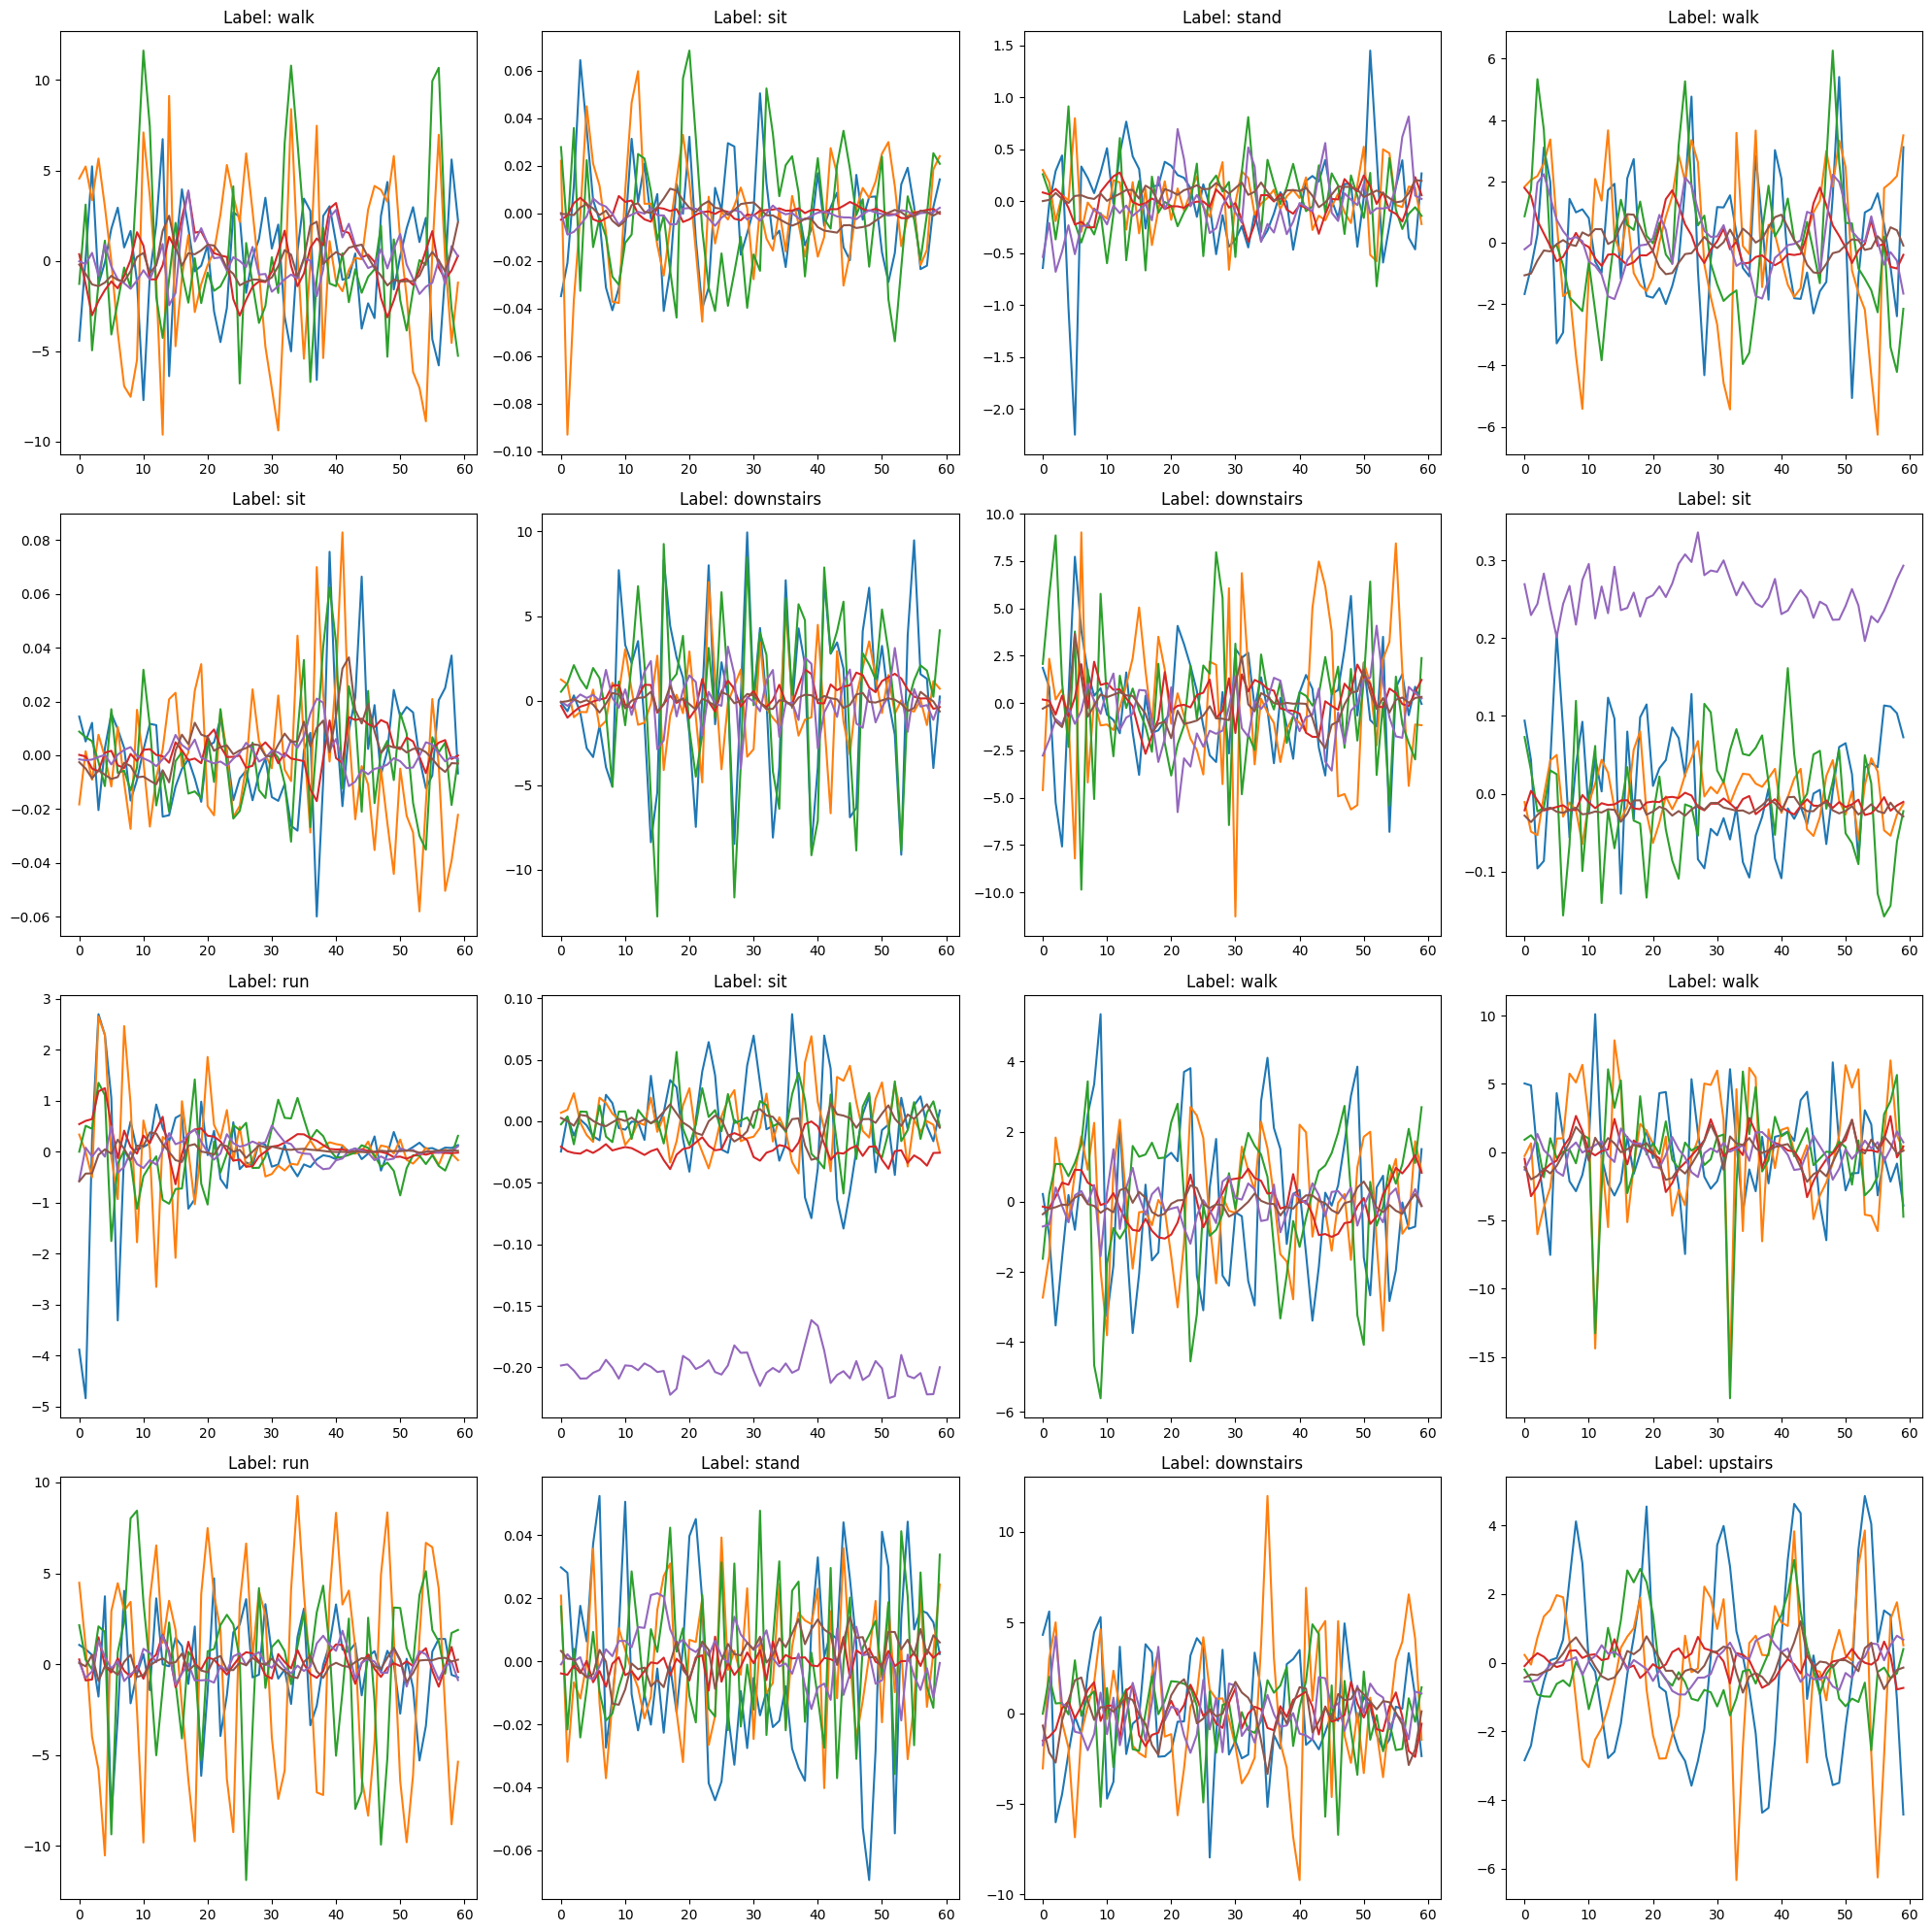

In [26]:
import matplotlib.pyplot as plt

def plot_batch(X_batch, y_batch):
    """
    Plota todos os b elementos do batch e escreve o título de cada subplot com o valor de y_batch[i].

    Parameters
    ----------
    X_batch : torch.Tensor
        O tensor contendo os dados do batch com shape (b, C, T).
    y_batch : torch.Tensor
        O tensor contendo os rótulos do batch com shape (b,).
    """
    num_samples = X_batch.shape[0]
    num_channels = X_batch.shape[1]
    time_steps = X_batch.shape[2]

    fig, axes = plt.subplots(num_samples // 4, 4, figsize=(20, 20))
    axes = axes.flatten()

    for i in range(num_samples):
        for j in range(num_channels):
            axes[i].plot(X_batch[i, j].cpu().numpy()) #, label=f'Channel {j+1}'
        axes[i].set_title(f'Label: {activities[y_batch[i].item()]}')
        #axes[i].legend()

    plt.tight_layout()
    plt.show()

# Exemplo de uso
# Supondo que você tenha um batch de dados
for batch in train_loader:
    X_batch, y_batch = batch
    plot_batch(X_batch, y_batch)
    break  # Apenas para plotar o primeiro batch

In [27]:
data_module.setup()

In [28]:
datamodule.setup("fit")
train_dataloader = datamodule.train_dataloader()

for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([8, 6, 60]) torch.Size([8])


### Defining Author GAN model

In [28]:
from minerva.models.nets.time_series.gans import GAN

generator = Genera().to(device)
discriminator = Discri().to(device)
encoder = Encod().to(device)

model = GAN(generator = generator,
            discriminator = discriminator, 
            encoder = encoder,
            loss_gen = nn.BCEWithLogitsLoss(),
            loss_dis = nn.BCEWithLogitsLoss()
            )
model

GAN(
  (gen): Genera(
    (l1): Linear(in_features=100, out_features=1024, bias=True)
    (l2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l3): ConvTranspose1d(256, 128, kernel_size=(10,), stride=(2,), padding=(4,))
    (l4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l5): ConvTranspose1d(128, 64, kernel_size=(10,), stride=(2,), padding=(4,))
    (l6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l7): ConvTranspose1d(64, 32, kernel_size=(10,), stride=(2,), padding=(4,))
    (l8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l9): ConvTranspose1d(32, 6, kernel_size=(10,), stride=(2,), padding=(6,))
  )
  (dis): Discri(
    (l1): Conv1d(6, 32, kernel_size=(10,), stride=(2,), padding=(6,))
    (l2): Conv1d(32, 64, kernel_size=(10,), stride=(2,), padding=(4,))
    (l3): Conv1d(64, 128, kernel_size=(10,), stride=(2,), padding=(

### Training model

In [29]:
from lightning.pytorch.loggers.csv_logs import CSVLogger

# Start logger
logger = CSVLogger(save_dir='./training', name='tcgan', version = 'pytorch_version')

# Start Callbacks
from callbacks import TSNECallback, KNNValidationCallback
tsne_callback = TSNECallback(image_save_dir = "Images/TSNE/Original", latent_dim=100)
knn_callback = KNNValidationCallback()

In [32]:
trainer = L.Trainer(accelerator='cpu', devices=1, callbacks=[], logger=logger, max_epochs=n_epochs)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/vinicius/Documentos/HIAAC/tcgan/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [33]:
trainer.fit(model = model, datamodule = data_module)

/home/vinicius/Documentos/HIAAC/tcgan/.venv/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./training/tcgan/pytorch_version exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/vinicius/Documentos/HIAAC/tcgan/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./training/tcgan/pytorch_version/checkpoints exists and is not empty.


RuntimeError: Training with multiple optimizers is only supported with manual optimization. Remove the `optimizer_idx` argument from `training_step`, set `self.automatic_optimization = False` and access your optimizers in `training_step` with `opt1, opt2, ... = self.optimizers()`.

### Showing results

In [28]:
import csv

def extract_losses(file_path, validation_flag = True, training_flag = False):
    train_generator_losses = []
    train_discriminator_losses = []
    validation_generator_losses = []
    validation_discriminator_losses = []

    with open(file_path, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            if 'train_generator_loss' in row and row['train_generator_loss']:
                train_generator_losses.append(float(row['train_generator_loss']))
            if 'train_discriminator_loss' in row and row['train_discriminator_loss']:
                train_discriminator_losses.append(float(row['train_discriminator_loss']))
            if 'validation_generator_loss' in row and row['validation_generator_loss']:
                validation_generator_losses.append(float(row['validation_generator_loss']))
            if 'validation_discriminator_loss' in row and row['validation_discriminator_loss']:
                validation_discriminator_losses.append(float(row['validation_discriminator_loss']))
    if validation_flag and training_flag:
        return train_generator_losses, train_discriminator_losses, validation_generator_losses, validation_discriminator_losses
    elif validation_flag:
        return validation_generator_losses, validation_discriminator_losses
    else:
        return train_generator_losses, train_discriminator_losses

# Exemplo de uso
file_path = '/home/vinicius/Documentos/HIAAC/tcgan/Minerva_experiments/training/tcgan/pytorch_version/metrics.csv'
validation_generator_losses, validation_discriminator_losses = extract_losses(file_path)
print("Validation Generator Losses:", validation_generator_losses)
print("Validation Discriminator Losses:", validation_discriminator_losses)

Validation Generator Losses: [1.1739956140518188, 0.20727160573005676, 1.139336109161377, 1.1708621978759766, 0.6219701766967773, 0.7014349699020386, 1.2439440488815308, 0.5976077914237976, 0.8966944813728333, 1.2088700532913208, 0.7200535535812378, 0.982118546962738, 0.624804675579071, 0.7283465266227722, 0.7145745754241943, 0.7256196141242981, 1.081599473953247, 1.1107177734375, 1.045938491821289, 0.62309330701828, 1.0877456665039062, 0.9895164966583252, 0.9265772104263306, 1.3178997039794922, 1.1810359954833984, 0.8669221997261047, 0.5444662570953369, 0.8117393255233765, 0.9602962136268616, 0.707416832447052, 0.9398605227470398, 0.5452127456665039, 0.8174925446510315, 0.7748663425445557, 0.8908532857894897, 0.8098768591880798, 1.103575348854065, 1.0193266868591309, 1.0550806522369385, 1.0470918416976929, 0.43386152386665344, 0.8961708545684814, 1.1434855461120605, 0.9869946241378784, 0.7692845463752747, 1.3722730875015259, 0.9243203401565552, 0.7196088433265686, 0.9202863574028015, 

In [30]:
fig3 = go.Figure()

fig3.add_trace(go.Scatter(y=validation_discriminator_losses, mode="lines", showlegend=True, name='dLoss'))
fig3.add_trace(go.Scatter(y=validation_generator_losses, mode="lines", showlegend=True, name='gLoss'))
fig3.update_layout(width=1000, height=600, title="TTSGAN Losses")

fig3.show()

### Saving Model

In [31]:
save_model(model.gen, model.dis, 4)

saving model in  ./trained_models/1/experiment_5_author_minerva_training/model.pth


### Training minerva-like model 

In [22]:
data_module = CustomDataModule(X_tensor, y_tensor, batch_size=16)

In [23]:
from TCGAN_model import TCGAN_Discriminator, TCGAN_Generator, TCGAN_Encoder
from minerva.models.nets.time_series.gans import GAN

generator = TCGAN_Generator().to(device)
discriminator = TCGAN_Discriminator().to(device)
encoder = TCGAN_Encoder().to(device)

model = GAN(generator = generator,
            discriminator = discriminator, 
            encoder = encoder,
            loss_gen = nn.BCEWithLogitsLoss(),
            loss_dis = nn.BCEWithLogitsLoss(),
            )
model

GAN(
  (gen): TCGAN_Generator(
    (l1): Linear(in_features=100, out_features=1024, bias=True)
    (l2): IgnoreWhenBatch1(
      (module): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (l3): ConvTranspose1d(256, 128, kernel_size=(10,), stride=(2,), padding=(4,))
    (l4): IgnoreWhenBatch1(
      (module): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (l5): ConvTranspose1d(128, 64, kernel_size=(10,), stride=(2,), padding=(4,))
    (l6): IgnoreWhenBatch1(
      (module): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (l7): ConvTranspose1d(64, 32, kernel_size=(10,), stride=(2,), padding=(4,))
    (l8): IgnoreWhenBatch1(
      (module): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (l9): ConvTranspose1d(32, 6, kernel_size=(10,), stride=(2,), padding=(6,))
  )
  (dis): TCGAN_Discriminator(
    (l1): Conv1d(6, 32, ke

In [24]:
from lightning.pytorch.loggers.csv_logs import CSVLogger

logger = CSVLogger(save_dir='./training', name='tcgan', version = 'lightning_version')

In [25]:
trainer = L.Trainer(accelerator='cpu', devices=1, callbacks=[], logger=logger, max_epochs=n_epochs)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/vinicius/Documentos/HIAAC/tcgan/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [26]:
trainer.fit(model = model, datamodule = data_module)

/home/vinicius/Documentos/HIAAC/tcgan/.venv/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./training/tcgan/lightning_version exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/vinicius/Documentos/HIAAC/tcgan/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./training/tcgan/lightning_version/checkpoints exists and is not empty.

  | Name     | Type                | Params | Mode 
---------------------------------------------------------
0 | gen      | TCGAN_Generator     | 538 K  | train
1 | dis      | TCGAN_Discriminator | 434 K  | train
2 | enc      | TCGAN_Encoder       | 433 K  | train
3 | loss_gen | BCEWithLogitsLoss   | 0      | train
4 | loss_dis | BCEWithLogitsLoss   | 0      | train
---------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/vinicius/Documentos/HIAAC/tcgan/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/vinicius/Documentos/HIAAC/tcgan/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 1840/1840 [01:51<00:00, 16.48it/s, v_num=sion]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1840/1840 [01:51<00:00, 16.47it/s, v_num=sion]


### Showing results

In [29]:
file_path = '/home/vinicius/Documentos/HIAAC/tcgan/Minerva_experiments/training/tcgan/lightning_version/metrics.csv'
validation_generator_losses, validation_discriminator_losses = extract_losses(file_path)
print("Generator Losses:", validation_generator_losses)
print("Discriminator Losses:", validation_discriminator_losses)

Generator Losses: [4.303913374315016e-05, 0.00017134226800408214, 0.21584226191043854, 0.2831308841705322, 1.8804006576538086, 1.4693810939788818, 1.4097660779953003, 0.8049099445343018, 0.676582396030426, 1.7081577777862549, 0.658595860004425, 1.4726008176803589, 1.3891465663909912, 0.8568078875541687, 1.0099549293518066, 1.0059854984283447, 1.0985524654388428, 1.450812816619873, 0.9967328906059265, 1.0443696975708008, 1.7734971046447754, 1.1928073167800903, 0.8597253561019897, 1.4465290307998657, 0.8579956293106079, 1.9695909023284912, 1.4359824657440186, 1.0224589109420776, 1.1035382747650146, 1.3457955121994019, 2.035935401916504, 1.4677783250808716, 0.6311929225921631, 1.3471636772155762, 0.7582072019577026, 1.1946120262145996, 1.3910433053970337, 1.1460208892822266, 0.29789304733276367, 1.1554068326950073, 1.6038687229156494, 0.8958027362823486, 0.9827556014060974, 0.5287713408470154, 1.7889865636825562, 1.0637682676315308, 0.4416483938694, 1.731616497039795, 0.8306389451026917, 

In [30]:
fig4 = go.Figure()

fig4.add_trace(go.Scatter(y=validation_discriminator_losses, mode="lines", showlegend=True, name='dLoss'))
fig4.add_trace(go.Scatter(y=validation_generator_losses, mode="lines", showlegend=True, name='gLoss'))
fig4.update_layout(width=1000, height=600, title="TTSGAN Losses")

fig4.show()

### Saving Model

In [42]:
save_model(model.gen, model.dis, 5)

saving model in  ./trained_models/1/experiment_6_enhanced_minerva_training/model.pth
